# 08. Natural Language Processing with TensorFlow  NLP

文本--> 数字-> 模型-> 训练模型-> 寻找模式-> 使用模式（生成预测）

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-example-nlp-problems.png)
*A handful of example natural language processing (NLP) and natural language understanding (NLU) problems. These are also often referred to as sequence problems (going from one sequence to another).*

The main goal of [natural language processing (NLP)](https://becominghuman.ai/a-simple-introduction-to-natural-language-processing-ea66a1747b32) is to derive information from natural language.

Natural language is a broad term but you can consider it to cover any of the following:
* Text (such as that contained in an email, blog post, book, Tweet)
* Speech (a conversation you have with a doctor, voice commands you give to a smart speaker)

Under the umbrellas of text and speech there are many different things you might want to do.

If you're building an email application, you might want to scan incoming emails to see if they're spam or not spam (classification).

If you're trying to analyse customer feedback complaints, you might want to discover which section of your business they're for.

> 🔑 **Note:** Both of these types of data are often referred to as *sequences* (a sentence is a sequence of words). So a common term you'll come across in NLP problems is called *seq2seq*, in other words, finding information in one sequence to produce another sequence (e.g. converting a speech command to a sequence of text-based steps).

To get hands-on with NLP in TensorFlow, we're going to practice the steps we've used previously but this time with text data:

```
Text -> turn into numbers -> build a model -> train the model to find patterns -> use patterns (make predictions)
```

> 📖 **Resource:** For a great overview of NLP and the different problems within it, read the article [*A Simple Introduction to Natural Language Processing*](https://becominghuman.ai/a-simple-introduction-to-natural-language-processing-ea66a1747b32).

## What we're going to cover

Let's get specific hey?

* Downloading a text dataset
* Visualizing text data
* Converting text into numbers using tokenization
* Turning our tokenized text into an embedding
* Modelling a text dataset
  * Starting with a baseline (TF-IDF)
  * Building several deep learning text models
    * Dense, LSTM, GRU, Conv1D, Transfer learning
* Comparing the performance of each our models
* Combining our models into an ensemble
* Saving and loading a trained model
* Find the most wrong predictions

## How you should approach this notebook

You can read through the descriptions and the code (it should all run, except for the cells which error on purpose), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to write more code.

> 📖 **Resource:** See the full set of course materials on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning

In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2025-01-22 10:27:49.762145


## Check for GPU

In order for our deep learning models to run as fast as possible, we'll need access to a GPU.

In Google Colab, you can set this up by going to Runtime -> Change runtime type -> Hardware accelerator -> GPU.

After selecting GPU, you may have to restart the runtime.

In [2]:
!nvidia-smi -L

/bin/bash: nvidia-smi: command not found


## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script containing our helper functions can be [found on GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py).

In [3]:
import os
if not os.path.exists('helper_functions.py'):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [4]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

2025-01-22 10:27:49.931995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-22 10:27:50.041074: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-22 10:27:50.046171: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-22 10:27:50.046185: I tensorflow/stream_executor/cuda/cuda

## Download a text dataset

Let's start by download a text dataset. We'll be using the [Real or Not?](https://www.kaggle.com/c/nlp-getting-started/data) dataset from Kaggle which contains text-based Tweets about natural disasters. 

The Real Tweets are actually about disasters, for example:

```
Jetstar and Virgin forced to cancel Bali flights again because of ash from Mount Raung volcano
```

The Not Real Tweets are Tweets not about disasters (they can be on anything), for example:

```
'Education is the most powerful weapon which you can use to change the world.' Nelson #Mandela #quote
```

For convenience, the dataset has been [downloaded from Kaggle](https://www.kaggle.com/c/nlp-getting-started/data) (doing this requires a Kaggle account) and uploaded as a downloadable zip file. 

> 🔑 **Note:** The original downloaded data has not been altered to how you would download it from Kaggle.

In [5]:
if not os.path.exists("nlp_getting_started.zip"):
    !wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
if not os.path.exists("nlp_getting_started"):
    unzip_data("nlp_getting_started.zip")

Unzipping `nlp_getting_started.zip` gives the following 3 `.csv` files:

三个csv文件，sample_submission.csv 是提交给Kaggle竞赛的样例文件，train.csv 是训练数据，test.csv 是测试数据。

* `sample_submission.csv` - an example of the file you'd submit to the Kaggle competition of your model's predictions.
* `train.csv` - training samples of real and not real diaster Tweets.
* `test.csv` - testing samples of real and not real diaster Tweets.

## Visualizing a text dataset  可视化数据

Once you've acquired a new dataset to work with, what should you do first?

Explore it? Inspect it? Verify it? Become one with it?

All correct.

Remember the motto: visualize, visualize, visualize.

Right now, our text data samples are in the form of `.csv` files. For an easy way to make them visual, let's turn them into pandas DataFrame's.

> 📖 **Reading:** You might come across text datasets in many different formats. Aside from CSV files (what we're working with), you'll probably encounter `.txt` files and `.json` files too. For working with these type of files, I'd recommend reading the two following articles by RealPython:
* [How to Read and Write Files in Python](https://realpython.com/read-write-files-python/)
* [Working with JSON Data in Python](https://realpython.com/python-json/)

In [6]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# shuffle
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


Notice how the training data has a `"target"` column.

We're going to be writing code to find patterns (e.g. different combinations of words) in the `"text"` column of the training dataset to predict the value of the `"target"` column.

The test dataset doesn't have a `"target"` column.

```
Inputs (text column) -> Machine Learning Algorithm -> Outputs (target column)
```

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-text-classification-inputs-and-outputs.png)
*Example text classification inputs and outputs for the problem of classifying whether a Tweet is about a disaster or not.*

In [8]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
# 类别分布
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [10]:
len(train_df),len(test_df),len(train_df)+len(test_df)

(7613, 3263, 10876)

Alright, seems like we've got a decent amount of training and test data. If anything, we've got an abundance of testing examples, usually a split of 90/10 (90% training, 10% testing) or 80/20 is suffice.

Okay, time to visualize, let's write some code to visualize random text samples.

> 🤔 **Question:** Why visualize random samples? You could visualize samples in order but this could lead to only seeing a certain subset of data. Better to visualize a substantial quantity (100+) of random samples to get an idea of the different kinds of data you're working with. In machine learning, never underestimate the power of randomness.

随机抽取100条数据，要多看随机数据的分布情况

In [11]:
import random

rand_num = random.randint(0, len(train_df)-5)
for row in train_df.iloc[rand_num:rand_num+5].itertuples():
    text = row.text
    target = row.target
    print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
    print(f"Text:\n{text}\n")
    print("---"*10)
    

Target: 1 (real disaster)
Text:
Militants attack police post in Udhampur; 2 SPOs injured | LiveMint http://t.co/Rptouz2iJs | http://t.co/69mLhfefhr #AllTheNews

------------------------------
Target: 1 (real disaster)
Text:
BREAKING: Obama Officials GAVE Muslim Terrorist the Weapon Used in Texas Attack http://t.co/qi8QDw5dFG

------------------------------
Target: 1 (real disaster)
Text:
Delhi Government to Provide Free Treatment to Acid Attack Victims in Private Hospitals http://t.co/H6PM1W7elL

------------------------------
Target: 1 (real disaster)
Text:
New post from @darkreading http://t.co/8eIJDXApnp New SMB Relay Attack Steals User Credentials Over Internet

------------------------------
Target: 1 (real disaster)
Text:
Israeli forces raid home of alleged car attack suspect http://t.co/3GVUS8NPpy #palestine

------------------------------


### Split data into training and validation sets  划分训练集和验证集

Since the test set has no labels and we need a way to evalaute our trained models, we'll split off some of the training data and create a validation set.

When our model trains (tries patterns in the Tweet samples), it'll only see data from the training set and we can see how it performs on unseen data using the validation set.

We'll convert our splits from pandas Series datatypes to lists of strings (for the text) and lists of ints (for the labels) for ease of use later.

To split our training dataset and create a validation dataset, we'll use Scikit-Learn's [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method and dedicate 10% of the training samples to the validation set.

In [12]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42)

In [13]:
len(train_sentences),len(train_labels),len(val_sentences),len(val_labels)

(6851, 6851, 762, 762)

In [14]:
train_sentences[:10],train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

 ## Converting text into numbers 文本数字化

两种数字化操作:
1、tokenization:单词级，字母级，subword级
2、embedding: create embeddings，用训练好的模型的embedding层输出，更能表示单词之间的关系

Wonderful! We've got a training set and a validation set containing Tweets and labels.

Our labels are in numerical form (`0` and `1`) but our Tweets are in string form.

> 🤔 **Question:** What do you think we have to do before we can use a machine learning algorithm with our text data? 

If you answered something along the lines of "turn it into numbers", you're correct. A machine learning algorithm requires its inputs to be in numerical form.

In NLP, there are two main concepts for turning text into numbers:
* **Tokenization** - A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:
  1. Using **word-level tokenization** with the sentence "I love TensorFlow" might result in "I" being `0`, "love" being `1` and "TensorFlow" being `2`. In this case, every word in a sequence considered a single **token**.
  2. **Character-level tokenization**, such as converting the letters A-Z to values `1-26`. In this case, every character in a sequence considered a single **token**.
  3. **Sub-word tokenization** is in between word-level and character-level tokenization. It involves breaking invidual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple **tokens**.
* **Embeddings** - An embedding is a representation of natural language which can be learned. Representation comes in the form of a **feature vector**. For example, the word "dance" could be represented by the 5-dimensional vector `[-0.8557, 0.5559, -0.3332, 0.9877, 0.1112]`. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings: 
  1. **Create your own embedding** - Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)) and an embedding representation will be learned during model training.
  2. **Reuse a pre-learned embedding** - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-tokenization-vs-embedding.png)
*Example of **tokenization** (straight mapping from word to number) and **embedding** (richer representation of relationships between tokens).*

> 🤔 **Question:** What level of tokenzation should I use? What embedding should should I choose?

It depends on your problem. You could try character-level tokenization/embeddings and word-level tokenization/embeddings and see which perform best. You might even want to try stacking them (e.g. combining the outputs of your embedding layers using [`tf.keras.layers.concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate)). 

If you're looking for pre-trained word embeddings, [Word2vec embeddings](http://jalammar.github.io/illustrated-word2vec/), [GloVe embeddings](https://nlp.stanford.edu/projects/glove/) and many of the options available on [TensorFlow Hub](https://tfhub.dev/s?module-type=text-embedding) are great places to start.

> 🔑 **Note:** Much like searching for a pre-trained computer vision model, you can search for pre-trained word embeddings to use for your problem. Try searching for something like "use pre-trained word embeddings in TensorFlow".

### Text vectorization (tokenization)  TextVectorization将单词token化

Enough talking about tokenization and embeddings, let's create some.

We'll practice tokenzation (mapping our words to numbers) first.

To tokenize our words, we'll use the helpful preprocessing layer [`tf.keras.layers.experimental.preprocessing.TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization).

The `TextVectorization` layer takes the following parameters:
* `max_tokens` - The maximum number of words in your vocabulary (e.g. 20000 or the number of unique words in your text), includes a value for OOV (out of vocabulary) tokens. 
* `standardize` - Method for standardizing text. Default is `"lower_and_strip_punctuation"` which lowers text and removes all punctuation marks.
* `split` - How to split text, default is `"whitespace"` which splits on spaces.
* `ngrams` - How many words to contain per token split, for example, `ngrams=2` splits tokens into continuous sequences of 2.
* `output_mode` -  How to output tokens, can be `"int"` (integer mapping), `"binary"` (one-hot encoding), `"count"` or `"tf-idf"`. See documentation for more.
* `output_sequence_length` - Length of tokenized sequence to output. For example, if `output_sequence_length=150`, all tokenized sequences will be 150 tokens long.
* `pad_to_max_tokens` - Defaults to `False`, if `True`, the output feature axis will be padded to `max_tokens` even if the number of unique tokens in the vocabulary is less than `max_tokens`. Only valid in certain modes, see docs for more.

Let's see it in action.

In [15]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [16]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization # after TensorFlow 2.6

# Before TensorFlow 2.6
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization 
# Note: in TensorFlow 2.6+, you no longer need "layers.experimental.preprocessing"

In [17]:
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) 

2025-01-22 10:27:51.865988: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-01-22 10:27:51.866012: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-01-22 10:27:51.866024: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iv-yddi5wlhj4qc6il2vxqe): /proc/driver/nvidia/version does not exist
2025-01-22 10:27:51.866237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We've initialized a `TextVectorization` object with the default settings but let's customize it a little bit for our own use case.

In particular, let's set values for `max_tokens` and `output_sequence_length`.

For `max_tokens` (the number of words in the vocabulary), multiples of 10,000 (`10,000`, `20,000`, `30,000`) or the exact number of unique words in your text (e.g. `32,179`) are common values.

For our use case, we'll use `10,000`.

And for the `output_sequence_length` we'll use the average number of tokens per Tweet in the training set. But first, we'll need to find it.

In [18]:
sum([len(i.split()) for i in train_sentences])/len(train_sentences)

14.901036345059115

In [19]:
max_vocab_length = 10000 
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [20]:
type(train_sentences)

numpy.ndarray

In [21]:
# fit train data
text_vectorizer.adapt(train_sentences)

In [22]:
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [23]:
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
late night mcdonalds with friends = hilarious although my car is wrecked and there's half a steak pastie in the industrial estate      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1394,  285, 3647,   14,  819, 1519, 4148,   13,  127,    9,  337,
           7,  264,  575,    3]])>

In [24]:
words_in_vocab = text_vectorizer.get_vocabulary()
top5_words = words_in_vocab[:5]
bottom_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top5_words}")
print(f"Bottom 5 least common words: {bottom_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer  tf.keras.layers.Embedding 实现embedding

We've got a way to map our text to numbers. How about we go a step further and turn those numbers into an embedding?

The powerful thing about an embedding is it can be learned during training. This means rather than just being static (e.g. `1` = I, `2` = love, `3` = TensorFlow), a word's numeric representation can be improved as a model goes through data samples.

We can see what an embedding of a word looks like by using the [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer. 

参数：input_dim 表示词汇表大小，output_dim表示输出的embedding向量维度，embeddings_initializer表示embedding矩阵的初始化方式，input_length表示输入的序列长度

The main parameters we're concerned about here are:
* `input_dim` - The size of the vocabulary (e.g. `len(text_vectorizer.get_vocabulary()`).
* `output_dim` - The size of the output embedding vector, for example, a value of `100` outputs a  feature vector of size 100 for each word.
* `embeddings_initializer` - How to initialize the embeddings matrix, default is `"uniform"` which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.
* `input_length` - Length of sequences being passed to embedding layer.

Knowing these, let's make an embedding layer.

In [25]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, 
                             output_dim=64,
                             embeddings_initializer="uniform",
                             input_length=max_length,
                             name="embedding_1")
embedding

In [26]:
# 案例
random_sentence = random.choice(train_sentences)  
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

random_sentence_int = text_vectorizer([random_sentence])
print(f"random_sentence_int:{random_sentence_int}")
sample_embed = embedding(random_sentence_int)
sample_embed

Original text:
7:13pm #MAPLERIDGE Lougheed Hwy EB is closed between 203rd and Dewdney Trunk Rd because of Collision. ETO is between 8:00 PM and 9:00 PM.      

Embedded version:
random_sentence_int:[[   1    1    1 1838 3901    9  959 1323    1    7    1 4370  765  152
     6]]


<tf.Tensor: shape=(1, 15, 64), dtype=float32, numpy=
array([[[-1.81695819e-02,  2.90265717e-02,  3.18275727e-02,
          3.36486138e-02,  3.00082900e-02, -7.18151405e-03,
          4.67654318e-03,  1.02014430e-02, -7.36920908e-03,
         -2.08133347e-02, -4.35255878e-02,  4.69939224e-02,
          3.21924426e-02, -1.35521889e-02, -3.21945176e-02,
         -6.20983541e-04, -1.43146627e-02, -1.57124884e-02,
         -3.09010874e-02, -4.87412326e-02, -6.08097389e-03,
          4.18156870e-02,  2.72732414e-02,  4.39486988e-02,
          2.03671940e-02,  6.57899305e-03, -3.52343917e-02,
         -2.96069868e-02,  2.34069116e-02,  2.90972851e-02,
          2.38841809e-02, -3.41748372e-02,  7.89452717e-03,
          9.39922407e-03,  3.47914211e-02,  3.39226760e-02,
         -1.27207115e-03, -8.47246498e-03, -4.10997756e-02,
          4.99075912e-02, -3.52857336e-02,  2.74533033e-03,
          1.55851282e-02, -3.94850150e-02, -3.44061852e-02,
         -3.77968773e-02,  3.42959426e-02,  4.4

In [27]:
# 单个词映射出的embedding 向量
sample_embed[0][0] 

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([-0.01816958,  0.02902657,  0.03182757,  0.03364861,  0.03000829,
       -0.00718151,  0.00467654,  0.01020144, -0.00736921, -0.02081333,
       -0.04352559,  0.04699392,  0.03219244, -0.01355219, -0.03219452,
       -0.00062098, -0.01431466, -0.01571249, -0.03090109, -0.04874123,
       -0.00608097,  0.04181569,  0.02727324,  0.0439487 ,  0.02036719,
        0.00657899, -0.03523439, -0.02960699,  0.02340691,  0.02909729,
        0.02388418, -0.03417484,  0.00789453,  0.00939922,  0.03479142,
        0.03392268, -0.00127207, -0.00847246, -0.04109978,  0.04990759,
       -0.03528573,  0.00274533,  0.01558513, -0.03948501, -0.03440619,
       -0.03779688,  0.03429594,  0.04467485,  0.02490461,  0.02413029,
        0.02721281,  0.02395291, -0.04985044,  0.01375904, -0.04789757,
        0.0124825 ,  0.02578551, -0.02023869,  0.0372344 , -0.01603024,
        0.04159037, -0.0224876 , -0.0245541 ,  0.00578309], dtype=float32)>

These values might not mean much to us but they're what our computer sees each word as. When our model looks for patterns in different samples, these values will be updated as necessary.

## Modelling a text dataset  模型化

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-inputs-and-outputs-with-shapes-and-models-were-going-to-build.png)
*Once you've got your inputs and outputs prepared, it's a matter of figuring out which machine learning model to build in between them to bridge the gap.*

Now that we've got a way to turn our text data into numbers, we can start to build machine learning models to model it.

To get plenty of practice, we're going to build a series of different models, each as its own experiment. We'll then compare the results of each model and see which one performed best.

More specifically, we'll be building the following:
* **Model 0**: Naive Bayes (baseline)
* **Model 1**: Feed-forward neural network (dense model)
* **Model 2**: LSTM model
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
* **Model 5**: 1D Convolutional Neural Network
* **Model 6**: TensorFlow Hub Pretrained Feature Extractor
* **Model 7**: Same as model 6 with 10% of training data

Model 0 is the simplest to acquire a baseline which we'll expect each other of the other deeper models to beat.

Each experiment will go through the following steps:
* Construct the model
* Train the model
* Make predictions with the model
* Track prediction evaluation metrics for later comparison

Let's get started.

### Model 0: Getting a baseline  基准模型 TF-IDF

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll create a Scikit-Learn Pipeline using the TF-IDF (term frequency-inverse document frequency) formula to convert our words to numbers and then model them with the [Multinomial Naive Bayes algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB). This was chosen via referring to the [Scikit-Learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

> 📖 **Reading:** The ins and outs of TF-IDF algorithm is beyond the scope of this notebook, however, the curious reader is encouraged to check out the [Scikit-Learn documentation for more](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting).

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [29]:
baseline_score = model0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of 79.27%


In [30]:
baseline_preds = model0.predict(val_sentences)
baseline_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

### Creating an evaluation function for our model experiments  评估函数

We could evaluate these as they are but since we're going to be evaluating several models in the same way going forward, let's create a helper function which takes an array of predictions and ground truth labels and computes the following:
* Accuracy
* Precision
* Recall
* F1-score

> 🔑 **Note:** Since we're dealing with a classification problem, the above metrics are the most appropriate. If we were working with a regression problem, other metrics such as MAE (mean absolute error) would be a better choice.

In [31]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,roc_auc_score

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) 
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  auc = roc_auc_score(y_true, y_pred)
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1,
                  "auc":auc}
  return model_results

In [32]:
baseline_results = calculate_results(val_labels,baseline_preds)
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549,
 'auc': 0.7794019656838247}

### Model 1: A simple dense model  简单的dnn模型

The first "deep" model we're going to build is a single layer dense model. In fact, it's barely going to have a single layer. 

It'll take our text and labels as input, tokenize the text, create an embedding, find the average of the embedding (using Global Average Pooling) and then pass the average through a fully connected layer with one output unit and a sigmoid activation function.

If the previous sentence sounds like a mouthful, it'll make sense when we code it out (remember, if in doubt, code it out).

And since we're going to be building a number of TensorFlow deep learning models, we'll import our `create_tensorboard_callback()` function from `helper_functions.py` to keep track of the results of each. 

In [33]:
from helper_functions import create_tensorboard_callback

SAVE_DIR = "model_log"

In [34]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype='string') # 输入是一维的 strings
x = text_vectorizer(inputs) # 数字化
x = embedding(x) # embedding
x = layers.GlobalAveragePooling1D()(x)  # 全局平均池化
outputs = layers.Dense(1,activation='sigmoid')(x) # 输出
model1 = tf.keras.Model(inputs,outputs,name='model1')

model1.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model1.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 64)            640000    
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 640,065
Trainable params: 640,065
Non-trainabl

In [35]:
# 大部分的参数都在embedding层，64维度，10000个词，参数是640000
model1_history = model1.fit(train_sentences,train_labels,epochs=5,validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_log/simple_dense_model/20250122-102752
Epoch 1/5
215/215 [==============================] - 1s 3ms/step - loss: 0.6321 - accuracy: 0.6697 - val_loss: 0.5771 - val_accuracy: 0.7257
Epoch 2/5
215/215 [==============================] - 0s 2ms/step - loss: 0.4888 - accuracy: 0.7980 - val_loss: 0.4907 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 0s 2ms/step - loss: 0.3933 - accuracy: 0.8428 - val_loss: 0.4677 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 0s 2ms/step - loss: 0.3326 - accuracy: 0.8685 - val_loss: 0.4589 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 0s 2ms/step - loss: 0.2861 - accuracy: 0.8913 - val_loss: 0.4594 - val_accuracy: 0.7913


In [36]:
model1.evaluate(val_sentences,val_labels)

 1/24 [>.............................] - ETA: 0s - loss: 0.5675 - accuracy: 0.7500

24/24 [==============================] - 0s 785us/step - loss: 0.4594 - accuracy: 0.7913


[0.4594421088695526, 0.7913385629653931]

In [37]:
type(embedding)

keras.layers.core.embedding.Embedding

In [38]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 64) dtype=float32, numpy=
 array([[-0.01238398,  0.03976315,  0.05967141, ...,  0.00147118,
         -0.00120488,  0.00906573],
        [-0.02461476,  0.03500758,  0.03809715, ..., -0.01444725,
         -0.01653738, -0.00166482],
        [-0.01028796, -0.01531043,  0.01261931, ..., -0.0136078 ,
          0.01689295, -0.03572265],
        ...,
        [-0.02546743,  0.01498115,  0.01955494, ...,  0.0299913 ,
          0.00061687,  0.01210845],
        [-0.03546415,  0.03735868,  0.01723779, ...,  0.00926579,
          0.01255319, -0.02697073],
        [-0.06960812,  0.08935145,  0.07606605, ...,  0.09076706,
          0.09401847, -0.05873762]], dtype=float32)>]

In [39]:
embed_weights = model1.get_layer('embedding_1').get_weights()[0]
embed_weights,embed_weights.shape

(array([[-0.01238398,  0.03976315,  0.05967141, ...,  0.00147118,
         -0.00120488,  0.00906573],
        [-0.02461476,  0.03500758,  0.03809715, ..., -0.01444725,
         -0.01653738, -0.00166482],
        [-0.01028796, -0.01531043,  0.01261931, ..., -0.0136078 ,
          0.01689295, -0.03572265],
        ...,
        [-0.02546743,  0.01498115,  0.01955494, ...,  0.0299913 ,
          0.00061687,  0.01210845],
        [-0.03546415,  0.03735868,  0.01723779, ...,  0.00926579,
          0.01255319, -0.02697073],
        [-0.06960812,  0.08935145,  0.07606605, ...,  0.09076706,
          0.09401847, -0.05873762]], dtype=float32),
 (10000, 64))

In [40]:
model1_pred_probs = model1.predict(val_sentences)
model1_pred_probs[:10]

24/24 [==============================] - 0s 741us/step


array([[0.3801634 ],
       [0.76140225],
       [0.99346286],
       [0.13641238],
       [0.17425583],
       [0.9051495 ],
       [0.9056347 ],
       [0.98097146],
       [0.9245294 ],
       [0.22286959]], dtype=float32)

In [41]:
# 将预测值改为0，1
model1_preds =  tf.round(tf.squeeze(model1_pred_probs))
model1_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [42]:
model1_results = calculate_results(val_labels,model1_preds)
model1_results

{'accuracy': 0.7913385826771654,
 'precision': 0.7976012509315953,
 'recall': 0.7913385826771654,
 'f1': 0.78803568654912,
 'auc': 0.782088122605364}

In [43]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model1_results)

Baseline accuracy: 0.79, New accuracy: 0.79, Difference: -0.00
Baseline precision: 0.81, New precision: 0.80, Difference: -0.01
Baseline recall: 0.79, New recall: 0.79, Difference: -0.00
Baseline f1: 0.79, New f1: 0.79, Difference: 0.00
Baseline auc: 0.78, New auc: 0.78, Difference: 0.00


## Visualizing learned embeddings

Our first model (`model_1`) contained an embedding layer (`embedding`) which learned a way of representing words as feature vectors by passing over the training data.

Hearing this for the first few times may sound confusing.

So to further help understand what a text embedding is, let's visualize the embedding our model learned.

To do so, let's remind ourselves of the words in our vocabulary.


In [44]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab),words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [45]:
model1.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 64)            640000    
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 640,065
Trainable params: 640,065
Non-trainabl

In [46]:
embed_weights = model1.get_layer('embedding_1').get_weights()[0]
embed_weights,embed_weights.shape

(array([[-0.01238398,  0.03976315,  0.05967141, ...,  0.00147118,
         -0.00120488,  0.00906573],
        [-0.02461476,  0.03500758,  0.03809715, ..., -0.01444725,
         -0.01653738, -0.00166482],
        [-0.01028796, -0.01531043,  0.01261931, ..., -0.0136078 ,
          0.01689295, -0.03572265],
        ...,
        [-0.02546743,  0.01498115,  0.01955494, ...,  0.0299913 ,
          0.00061687,  0.01210845],
        [-0.03546415,  0.03735868,  0.01723779, ...,  0.00926579,
          0.01255319, -0.02697073],
        [-0.06960812,  0.08935145,  0.07606605, ...,  0.09076706,
          0.09401847, -0.05873762]], dtype=float32),
 (10000, 64))

Now we've got these two objects, we can use the [Embedding Projector tool](http://projector.tensorflow.org/_) to visualize our embedding. 

To use the Embedding Projector tool, we need two files:
* The embedding vectors (same as embedding weights).
* The meta data of the embedding vectors (the words they represent - our vocabulary).

Right now, we've got of these files as Python objects. To download them to file, we're going to [use the code example available on the TensorFlow word embeddings tutorial page](https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk).


In [47]:
# # Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
# import io

# # Create output writers
# out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
# out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# # Write embedding vectors and words to file
# for num, word in enumerate(words_in_vocab):
#   if num == 0: 
#      continue # skip padding token
#   vec = embed_weights[num]
#   out_m.write(word + "\n") # write words to file
#   out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
# out_v.close()
# out_m.close()

# # Download files locally to upload to Embedding Projector
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download("embedding_vectors.tsv")
#   files.download("embedding_metadata.tsv")

Once you've downloaded the embedding vectors and metadata, you can visualize them using Embedding Vector tool:
1. Go to  http://projector.tensorflow.org/  查看embedding的分布
2. Click on "Load data"
3. Upload the two files you downloaded (`embedding_vectors.tsv` and `embedding_metadata.tsv`)
4. Explore
5. Optional: You can share the data you've created by clicking "Publish"

What do you find?

Are words with similar meanings close together?

Remember, they might not be. The embeddings we downloaded are how our model interprets words, not necessarily how we interpret them. 

Also, since the embedding has been learned purely from Tweets, it may contain some strange values as Tweets are a very unique style of natural language.

> 🤔 **Question:** Do you have to visualize embeddings every time?

No. Although helpful for gaining an intuition of what natural language embeddings are, it's not completely necessary. Especially as the dimensions of your vocabulary and embeddings grow, trying to comprehend them would become an increasingly difficult task.

## Recurrent Neural Networks (RNN's) RNN系列模型

For our next series of modelling experiments we're going to be using a special kind of neural network called a **Recurrent Neural Network (RNN)**.

The premise of an RNN is simple: use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input (`X`) and compute an output (`y`) based on all previous inputs.

This concept is especially helpful when dealing with sequences such as passages of natural language text (such as our Tweets).

For example, when you read this sentence, you take into context the previous words when deciphering the meaning of the current word dog. 

See what happened there? 

I put the word "dog" at the end which is a valid word but it doesn't make sense in the context of the rest of the sentence.

When an RNN looks at a sequence of text (already in numerical form), the patterns it learns are continually updated based on the order of the sequence. 

For a simple example, take two sentences:
1. Massive earthquake last week, no?
2. No massive earthquake last week.

Both contain exactly the same words but have different meaning. The order of the words determines the meaning (one could argue punctuation marks also dictate the meaning but for simplicity sake, let's stay focused on the words).

Recurrent neural networks can be used for a number of sequence-based problems:
* **One to one:** one input, one output, such as image classification.
* **One to many:** one input, many outputs, such as image captioning (image input, a sequence of text as caption output).
* **Many to one:** many inputs, one outputs, such as text classification (classifying a Tweet as real diaster or not real diaster).
* **Many to many:** many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output).

LSTM、GRU、Bidirectional RNN 等模型

When you come across RNN's in the wild, you'll most likely come across variants of the following:
* Long short-term memory cells (LSTMs).
* Gated recurrent units (GRUs).
* Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).

Going into the details of each these is beyond the scope of this notebook (we're going to focus on using them instead), the main thing you should know for now is that they've proven very effective at modelling sequences.

For a deeper understanding of what's happening behind the scenes of the code we're about to write, I'd recommend the following resources:

> 📖 **Resources:**
> * [MIT Deep Learning Lecture on Recurrent Neural Networks](https://youtu.be/SEnXr6v2ifU) - explains the background of recurrent neural networks and introduces LSTMs.
> * [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) by Andrej Karpathy - demonstrates the power of RNN's with examples generating various sequences.
> * [Understanding LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Chris Olah - an in-depth (and technical) look at the mechanics of the LSTM cell, possibly the most popular RNN building block.


### Model 2: LSTM

With all this talk of what RNN's are and what they're good for, I'm sure you're eager to build one.

We're going to start with an LSTM-powered RNN.

To harness the power of the LSTM cell (LSTM cell and LSTM layer are often used interchangably) in TensorFlow, we'll use [`tensorflow.keras.layers.LSTM()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-RNN-architecture-coloured-block-edition.png)
*Coloured block example of the structure of an recurrent neural network.*

Our model is going to take on a very similar structure to `model_1`:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

The main difference will be that we're going to add an LSTM layer between our embedding and output.

And to make sure we're not getting reusing trained embeddings (this would involve data leakage between models, leading to an uneven comparison later on), we'll create another embedding layer (`model_2_embedding`) for our model. The `text_vectorizer` layer can be reused since it doesn't get updated during training.

> 🔑 **Note:** The reason we use a new embedding layer for each model is since the embedding layer is a *learned* representation of words (as numbers), if we were to use the same embedding layer (`embedding_1`) for each model, we'd be mixing what one model learned with the next. And because we want to compare our models later on, starting them with their own embedding layer each time is a better idea.

In [48]:
tf.random.set_seed(42)
model2_embedding = layers.Embedding(input_dim=max_vocab_length, output_dim=128,embeddings_initializer="uniform", input_length=max_length,name="embedding_2")
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = model2_embedding(x)
print(x.shape)
# LSTM
x = layers.LSTM(64)(x)
print(x.shape)
outputs = layers.Dense(1,activation="sigmoid")(x)
model2 = tf.keras.Model(inputs,outputs,name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [49]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

Looking good! You'll notice a fair few more trainable parameters within our LSTM layer than `model_1`. 

If you'd like to know where this number comes from, I recommend going through the above resources as well the following on calculating the number of parameters in an LSTM cell:
* [Stack Overflow answer to calculate the number of parameters in an LSTM cell](https://stackoverflow.com/questions/38080035/how-to-calculate-the-number-of-parameters-of-an-lstm-network) by Marcin Możejko
* [Calculating number of parameters in a LSTM unit and layer](https://medium.com/@priyadarshi.cse/calculating-number-of-parameters-in-a-lstm-unit-layer-7e491978e1e4) by Shridhar Priyadarshi

Now our first RNN model's compiled let's fit it to our training data, validating it on the validation data and tracking its training parameters using our TensorBoard callback.

In [50]:
# 大部分的参数都在embedding层，64维度，10000个词，参数是640000
model2_history = model2.fit(train_sentences,train_labels,epochs=10,validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="LSTM")])

Saving TensorBoard log files to: model_log/LSTM/20250122-102756
Epoch 1/10
215/215 [==============================] - 3s 9ms/step - loss: 0.0000e+00 - accuracy: 0.5728 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 2/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 3/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 4/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 5/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 6/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 7/10
215/215 [================

In [51]:
model2_pred_probs = model2.predict(val_sentences)
model2_pred_probs

24/24 [==============================] - 0s 2ms/step


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [52]:
model2_pred_probs.shape

(762, 1)

In [53]:
model2_pred_probs[:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [54]:
model2_preds = tf.round(tf.squeeze(model2_pred_probs))
model2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [55]:
model2_results = calculate_results(val_labels,model2_preds)
model2_results

/root/miniconda3/envs/torchai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.5433070866141733,
 'precision': 0.29518259036518074,
 'recall': 0.5433070866141733,
 'f1': 0.38253254057528524,
 'auc': 0.5}

In [56]:
compare_baseline_to_new_results(baseline_results,model2_results)

Baseline accuracy: 0.79, New accuracy: 0.54, Difference: -0.25
Baseline precision: 0.81, New precision: 0.30, Difference: -0.52
Baseline recall: 0.79, New recall: 0.54, Difference: -0.25
Baseline f1: 0.79, New f1: 0.38, Difference: -0.40
Baseline auc: 0.78, New auc: 0.50, Difference: -0.28


### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

> 📖 **Resource:** A full explanation of the GRU cell is beyond the scope of this noteook but I'd suggest the following resources to learn more:
* [Gated Recurrent Unit](https://en.wikipedia.org/wiki/Gated_recurrent_unit) Wikipedia page
* [Understanding GRU networks](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be) by Simeon Kostadinov

To use the GRU cell in TensorFlow, we can call the [`tensorflow.keras.layers.GRU()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) class.

The architecture of the GRU-powered model will follow the same structure we've been using:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

Again, the only difference will be the layer(s) we use between the embedding and the output.

In [57]:
tf.random.set_seed(42)
model3_embedding = layers.Embedding(input_dim=max_vocab_length, output_dim=128,embeddings_initializer="uniform", input_length=max_length,name="embedding_3")
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = model3_embedding(x)
print(x.shape)
# GRU
x = layers.GRU(64)(x)
print(x.shape)
outputs = layers.Dense(1,activation="sigmoid")(x)
model3 = tf.keras.Model(inputs,outputs,name="model_3_GRU")

(None, 15, 128)


(None, 64)


In [58]:
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [59]:
model3_history = model3.fit(train_sentences,train_labels,epochs=10,validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="LSTM")])

Saving TensorBoard log files to: model_log/LSTM/20250122-102814
Epoch 1/10


215/215 [==============================] - 3s 10ms/step - loss: 0.0000e+00 - accuracy: 0.5723 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 2/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 3/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 4/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 5/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 6/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 7/10
215/215 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_

In [60]:
model3_pred_probs = model3.predict(val_sentences)
model3_preds = tf.squeeze(tf.round(model3_pred_probs))
model3_results = calculate_results(val_labels,
                                  model3_preds)
model3_results

24/24 [==============================] - 0s 2ms/step


/root/miniconda3/envs/torchai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.5433070866141733,
 'precision': 0.29518259036518074,
 'recall': 0.5433070866141733,
 'f1': 0.38253254057528524,
 'auc': 0.5}

In [61]:
compare_baseline_to_new_results(baseline_results,model3_results)

Baseline accuracy: 0.79, New accuracy: 0.54, Difference: -0.25
Baseline precision: 0.81, New precision: 0.30, Difference: -0.52
Baseline recall: 0.79, New recall: 0.54, Difference: -0.25
Baseline f1: 0.79, New f1: 0.38, Difference: -0.40
Baseline auc: 0.78, New auc: 0.50, Difference: -0.28


### Model 4: Bidirectonal RNN model 

Look at us go! We've already built two RNN's with GRU and LSTM cells. Now we're going to look into another kind of RNN, the bidirectional RNN.

A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.

Intuitively, this can be thought of as if you were reading a sentence for the first time in the normal fashion (left to right) but for some reason it didn't make sense so you traverse back through the words and go back over them again (right to left).

In practice, many sequence models often see and improvement in performance when using bidirectional RNN's.

However, this improvement in performance often comes at the cost of longer training times and increased model parameters (since the model goes left to right and right to left, the number of trainable parameters doubles).

Okay enough talk, let's build a bidirectional RNN.

Once again, TensorFlow helps us out by providing the [`tensorflow.keras.layers.Bidirectional`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) class. We can use the `Bidirectional` class to wrap our existing RNNs, instantly making them bidirectional.

In [62]:
tf.random.set_seed(42)
model4_embedding = layers.Embedding(input_dim=max_vocab_length, output_dim=128,embeddings_initializer="uniform", input_length=max_length,name="embedding_4")
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = model4_embedding(x)
# GRU
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model4 = tf.keras.Model(inputs,outputs,name="model_4_Bidirectional")

model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [63]:
model4_history = model4.fit(train_sentences,train_labels,epochs=10,validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="Bidirectional")])

Saving TensorBoard log files to: model_log/Bidirectional/20250122-102834
Epoch 1/10
215/215 [==============================] - 5s 12ms/step - loss: 0.0000e+00 - accuracy: 0.5735 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 2/10
215/215 [==============================] - 2s 9ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 3/10
215/215 [==============================] - 2s 9ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 4/10
215/215 [==============================] - 2s 9ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 5/10
215/215 [==============================] - 2s 9ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 6/10
215/215 [==============================] - 2s 9ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 7/10
215/215 [======

In [64]:
model4_pred_probs = model4.predict(val_sentences)
model4_preds = tf.squeeze(tf.round(model4_pred_probs))
model4_results = calculate_results(val_labels,
                                  model4_preds)
model4_results

24/24 [==============================] - 1s 3ms/step


/root/miniconda3/envs/torchai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.5433070866141733,
 'precision': 0.29518259036518074,
 'recall': 0.5433070866141733,
 'f1': 0.38253254057528524,
 'auc': 0.5}

In [65]:
compare_baseline_to_new_results(baseline_results,model4_results)

Baseline accuracy: 0.79, New accuracy: 0.54, Difference: -0.25
Baseline precision: 0.81, New precision: 0.30, Difference: -0.52
Baseline recall: 0.79, New recall: 0.54, Difference: -0.25
Baseline f1: 0.79, New f1: 0.38, Difference: -0.40
Baseline auc: 0.78, New auc: 0.50, Difference: -0.28


## Convolutional Neural Networks for Text  CNN 应用在文本

You might've used convolutional neural networks (CNNs) for images before but they can also be used for sequences.

The main difference between using CNNs for images and sequences is the shape of the data. Images come in 2-dimensions (height x width) where as sequences are often 1-dimensional (a string of text).

So to use CNNs with sequences, we use a 1-dimensional convolution instead of a 2-dimensional convolution.

A typical CNN architecture for sequences will look like the following: 

```
Inputs (text) -> Tokenization -> Embedding -> Layers -> Outputs (class probabilities)
```

You might be thinking "that just looks like the architecture layout we've been using for the other models..."

And you'd be right.

The difference again is in the layers component. Instead of using an LSTM or GRU cell, we're going to use a [`tensorflow.keras.layers.Conv1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) layer followed by a [`tensorflow.keras.layers.GlobablMaxPool1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D) layer.

> 📖 **Resource:** The intuition here is explained succinctly in the paper [*Understanding Convolutional Neural Networks for Text Classification*](https://www.aclweb.org/anthology/W18-5408.pdf), where they state that CNNs classify text through the following steps:
1. 1-dimensional convolving filters are used as ngram detectors, each filter specializing in a closely-related family of ngrams (an ngram is a collection of n-words, for example, an ngram of 5 might result in "hello, my name is Daniel").
2. Max-pooling over time extracts the relevant ngrams for making a decision.
3. The rest of the network classifies the text based on this information.

> 


### Model 5: Conv1D

Before we build a full 1-dimensional CNN model, let's see a 1-dimensional convolutional layer (also called a **temporal convolution**) in action.

We'll first create an embedding of a sample of text and experiment passing it through a `Conv1D()` layer and `GlobalMaxPool1D()` layer.

In [66]:
embedding_test = embedding(text_vectorizer(["Hello world, how are you doing?"]))
conv1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu")
conv1d_output = conv1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv1d_output)
embedding_test.shape, conv1d_output.shape, max_pool_output.shape    

(TensorShape([1, 15, 64]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [67]:
embedding_test[:1], conv1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 64), dtype=float32, numpy=
 array([[[ 0.04927063,  0.0455859 , -0.03696341, -0.02716763,
          -0.04393656, -0.02666598, -0.02628189, -0.02066438,
          -0.00862695, -0.02994786,  0.01083384,  0.00841267,
          -0.04106066, -0.00559476, -0.01404158,  0.02035085,
          -0.0247621 , -0.01744848, -0.01688452,  0.04168949,
          -0.00381372,  0.02718107,  0.02218331,  0.02043347,
          -0.02060524, -0.0454086 , -0.03620398,  0.04254222,
          -0.01027236,  0.0498293 , -0.05122475,  0.01015221,
          -0.04058774,  0.02962366, -0.03387579, -0.01199133,
          -0.04449604,  0.00624861, -0.05035713,  0.03105379,
          -0.04941126, -0.0392956 , -0.02791278, -0.03757041,
           0.02001321,  0.02441015,  0.04983385,  0.00505213,
           0.03252229, -0.02273783,  0.02550583, -0.04352991,
           0.03043619,  0.00896313, -0.03817467, -0.00248338,
          -0.02504817,  0.02785878,  0.0046658 , -0.041079  ,
          -0.000

In [68]:
tf.random.set_seed(42)
model5_embedding = layers.Embedding(input_dim=max_vocab_length, output_dim=128,embeddings_initializer="uniform", input_length=max_length,name="embedding_5")
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = model5_embedding(x)
# CNN
x = layers.Conv1D(filters=32,kernel_size=5,activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model5 = tf.keras.Model(inputs,outputs,name="model_5_conv1D")

model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model5.summary()

Model: "model_5_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [69]:
model5_history = model5.fit(train_sentences,train_labels,epochs=10,validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="Bidirectional")])

Saving TensorBoard log files to: model_log/Bidirectional/20250122-102857
Epoch 1/10
215/215 [==============================] - 1s 4ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 2/10
215/215 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 3/10
215/215 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 4/10
215/215 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 5/10
215/215 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 6/10
215/215 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.5733 - val_loss: 0.0000e+00 - val_accuracy: 0.5433
Epoch 7/10
215/215 [=======

In [70]:
model5_pred_probs = model5.predict(val_sentences)
model5_preds = tf.squeeze(tf.round(model5_pred_probs))
model5_results = calculate_results(val_labels,
                                model5_preds)
model5_results

24/24 [==============================] - 0s 908us/step


/root/miniconda3/envs/torchai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.5433070866141733,
 'precision': 0.29518259036518074,
 'recall': 0.5433070866141733,
 'f1': 0.38253254057528524,
 'auc': 0.5}

In [71]:
compare_baseline_to_new_results(baseline_results,model5_results)

Baseline accuracy: 0.79, New accuracy: 0.54, Difference: -0.25
Baseline precision: 0.81, New precision: 0.30, Difference: -0.52
Baseline recall: 0.79, New recall: 0.54, Difference: -0.25
Baseline f1: 0.79, New f1: 0.38, Difference: -0.40
Baseline auc: 0.78, New auc: 0.50, Difference: -0.28


## Using Pretrained Embeddings (transfer learning for NLP)

For all of the previous deep learning models we've built and trained, we've created and used our own embeddings from scratch each time.

However, a common practice is to leverage pretrained embeddings through **transfer learning**. This is one of the main benefits of using deep models: being able to take what one (often larger) model has learned (often on a large amount of data) and adjust it for our own use case.

For our next model, instead of using our own embedding layer, we're going to replace it with a pretrained embedding layer.

More specifically, we're going to be using the [Universal Sentence Encoder](https://www.aclweb.org/anthology/D18-2029.pdf) from [TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/4) (a great resource containing a plethora of pretrained model resources for a variety of tasks).

> 🔑 **Note:** There are many different pretrained text embedding options on TensorFlow Hub, however, some require different levels of text preprocessing than others. Best to experiment with a few and see which best suits your use case.



### Model 6: TensorFlow Hub Pretrained Sentence Encoder  预训练encoder模型

The main difference between the embedding layer we created and the Universal Sentence Encoder is that rather than create a word-level embedding, the Universal Sentence Encoder, as you might've guessed, creates a whole sentence-level embedding.

Our embedding layer also outputs an a 128 dimensional vector for each word, where as, the Universal Sentence Encoder outputs a 512 dimensional vector for each sentence.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-USE-tensorflow-hub-encoder-decoder-model.png)
*The feature extractor model we're building through the eyes of an **encoder/decoder** model.*

> 🔑 **Note:** An **encoder** is the name for a model which converts raw data such as text into a numerical representation (feature vector), a **decoder** converts the numerical representation to a desired output.

As usual, this is best demonstrated with an example.

We can load in a TensorFlow Hub module using the [`hub.load()`](https://www.tensorflow.org/hub/api_docs/python/hub/load) method and passing it the target URL of the module we'd like to use, in our case, it's "https://tfhub.dev/google/universal-sentence-encoder/4".

Let's load the Universal Sentence Encoder model and test it on a couple of sentences.

In [72]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157022  0.02485909  0.02878049 -0.01271502  0.03971541  0.0882776
  0.02680985  0.05589838 -0.01068732 -0.00597293  0.00639324 -0.01819521
  0.00030815  0.0910589   0.05874645 -0.03180628  0.01512474 -0.05162928
  0.00991369 -0.06865346 -0.04209307  0.0267898   0.0301101   0.00321071
 -0.00337968 -0.04787361  0.02266718 -0.00985926 -0.04063615 -0.01292094
 -0.04666382  0.05630298 -0.03949255  0.00517684  0.02495828 -0.0701444
  0.02871509  0.04947679 -0.00633974 -0.08960192  0.02807122 -0.00808364
 -0.01360597  0.05998648 -0.10361788 -0.05195372  0.00232956 -0.02332528
 -0.03758107  0.03327729], shape=(50,), dtype=float32)


In [73]:
embed_samples[0].shape

TensorShape([512])

Passing our sentences to the Universal Sentence Encoder (USE) encodes them from strings to 512 dimensional vectors, which make no sense to us but hopefully make sense to our machine learning models.

Speaking of models, let's build one with the USE as our embedding layer.

We can convert the TensorFlow Hub USE module into a Keras layer using the [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) class.

> 🔑 **Note:** Due to the size of the USE TensorFlow Hub module, it may take a little while to download. Once it's downloaded though, it'll be cached and ready to use. And as with many TensorFlow Hub modules, there is a ["lite" version of the USE](https://tfhub.dev/google/universal-sentence-encoder-lite/2) which takes up less space but sacrifices some performance and requires more preprocessing steps. However, depending on your available compute power, the lite version may be better for your application use case.

In [74]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [75]:
# sentence encoder layer s使用报错，pip install tensorflow==2.10.0,使用该版本
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

model6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

model6.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [76]:
model6_history = model6.fit(train_sentences,train_labels,epochs=10,validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_log/tf_hub_sentence_encoder/20250122-102915
Epoch 1/10


215/215 [==============================] - 3s 5ms/step - loss: 0.5063 - accuracy: 0.7805 - val_loss: 0.4475 - val_accuracy: 0.7966
Epoch 2/10
215/215 [==============================] - 1s 4ms/step - loss: 0.4144 - accuracy: 0.8146 - val_loss: 0.4368 - val_accuracy: 0.8136
Epoch 3/10
215/215 [==============================] - 1s 4ms/step - loss: 0.3999 - accuracy: 0.8224 - val_loss: 0.4328 - val_accuracy: 0.8136
Epoch 4/10
215/215 [==============================] - 1s 4ms/step - loss: 0.3926 - accuracy: 0.8276 - val_loss: 0.4287 - val_accuracy: 0.8123
Epoch 5/10
215/215 [==============================] - 1s 4ms/step - loss: 0.3864 - accuracy: 0.8286 - val_loss: 0.4307 - val_accuracy: 0.8110
Epoch 6/10
215/215 [==============================] - 1s 4ms/step - loss: 0.3797 - accuracy: 0.8342 - val_loss: 0.4261 - val_accuracy: 0.8176
Epoch 7/10
215/215 [==============================] - 1s 4ms/step - loss: 0.3739 - accuracy: 0.8336 - val_loss: 0.4247 - val_accuracy: 0.8163
Epoch 8/10
215/21

In [77]:
model6_pred_probs = model6.predict(val_sentences)
model6_preds = tf.squeeze(tf.round(model6_pred_probs))
model6_results = calculate_results(val_labels,
                                model6_preds)
model6_results

24/24 [==============================] - 0s 3ms/step


{'accuracy': 0.821522309711286,
 'precision': 0.8260248375546463,
 'recall': 0.821522309711286,
 'f1': 0.8194798413883178,
 'auc': 0.8139888389138764}

In [78]:
# tensorflow hub 中的encoder模型效果明显比较好
compare_baseline_to_new_results(baseline_results,model6_results)

Baseline accuracy: 0.79, New accuracy: 0.82, Difference: 0.03
Baseline precision: 0.81, New precision: 0.83, Difference: 0.01
Baseline recall: 0.79, New recall: 0.82, Difference: 0.03
Baseline f1: 0.79, New f1: 0.82, Difference: 0.03
Baseline auc: 0.78, New auc: 0.81, Difference: 0.03


### Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data  10%的数据 encoder模型

One of the benefits of using transfer learning methods, such as, the pretrained embeddings within the USE is the ability to get great results on a small amount of data (the USE paper even mentions this in the abstract).

To put this to the test, we're going to make a small subset of the training data (10%), train a model and evaluate it.

In [79]:
### NOTE: Making splits like this will lead to data leakage ###
### (some of the training examples in the validation set) ###

# 因为train_df_shuffled 已经被切分了，所以 train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)，可能和验证集有交集


### WRONG WAY TO MAKE SPLITS (train_df_shuffled has already been split) ### 

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [80]:
import numpy as np
# 正确的分割数据
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [81]:
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [82]:
# train_labels_10_percent.value_counts()

In [83]:
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
Name: count, dtype: int64

In [84]:
# 从model6中复制model7

model7 = tf.keras.models.clone_model(model6)

model7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
)

model7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [85]:
model7_history = model7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_log/10_percent_tf_hub_sentence_encoder/20250122-102928
Epoch 1/5
22/22 [==============================] - 2s 22ms/step - loss: 0.6751 - accuracy: 0.6531 - val_loss: 0.6549 - val_accuracy: 0.7073
Epoch 2/5
22/22 [==============================] - 0s 8ms/step - loss: 0.6024 - accuracy: 0.8309 - val_loss: 0.5951 - val_accuracy: 0.7598
Epoch 3/5
22/22 [==============================] - 0s 8ms/step - loss: 0.5222 - accuracy: 0.8382 - val_loss: 0.5384 - val_accuracy: 0.7651
Epoch 4/5
22/22 [==============================] - 0s 8ms/step - loss: 0.4544 - accuracy: 0.8382 - val_loss: 0.5049 - val_accuracy: 0.7717
Epoch 5/5
22/22 [==============================] - 0s 8ms/step - loss: 0.4096 - accuracy: 0.8440 - val_loss: 0.4877 - val_accuracy: 0.7808


In [86]:
model7_pred_probs = model7.predict(val_sentences)
model7_preds = tf.squeeze(tf.round(model7_pred_probs))
model7_results = calculate_results(val_labels,
                                model7_preds)
model7_results

24/24 [==============================] - 0s 3ms/step


{'accuracy': 0.7808398950131233,
 'precision': 0.7861251265484451,
 'recall': 0.7808398950131233,
 'f1': 0.7775280856169867,
 'auc': 0.7717391304347825}

In [87]:
compare_baseline_to_new_results(baseline_results,model7_results)

Baseline accuracy: 0.79, New accuracy: 0.78, Difference: -0.01
Baseline precision: 0.81, New precision: 0.79, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01
Baseline auc: 0.78, New auc: 0.77, Difference: -0.01


## Comparing the performance of each of our models 对比模型效果

Woah. We've come a long way! From training a baseline to several deep models.

Now it's time to compare our model's results.

But just before we do, it's worthwhile mentioning, this type of practice is a standard deep learning workflow. Training various different models, then comparing them to see which one performed best and continuing to train it if necessary.

The important thing to note is that for all of our modelling experiments we used the same training data (except for `model_7` where we used 10% of the training data).

To visualize our model's performances, let's create a pandas DataFrame we our results dictionaries and then plot it.

In [88]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model1_results,
                                  "lstm": model2_results,
                                  "gru": model3_results,
                                  "bidirectional": model4_results,
                                  "conv1d": model5_results,
                                  "tf_hub_sentence_encoder": model6_results,
                                  "tf_hub_10_percent_data": model7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1,auc
baseline,0.792651,0.811139,0.792651,0.786219,0.779402
simple_dense,0.791339,0.797601,0.791339,0.788036,0.782088
lstm,0.543307,0.295183,0.543307,0.382533,0.500000
gru,0.543307,0.295183,0.543307,0.382533,0.500000
bidirectional,0.543307,0.295183,0.543307,0.382533,0.500000
conv1d,0.543307,0.295183,0.543307,0.382533,0.500000
tf_hub_sentence_encoder,0.821522,0.826025,0.821522,0.819480,0.813989
tf_hub_10_percent_data,0.780840,0.786125,0.780840,0.777528,0.771739


<Axes: >

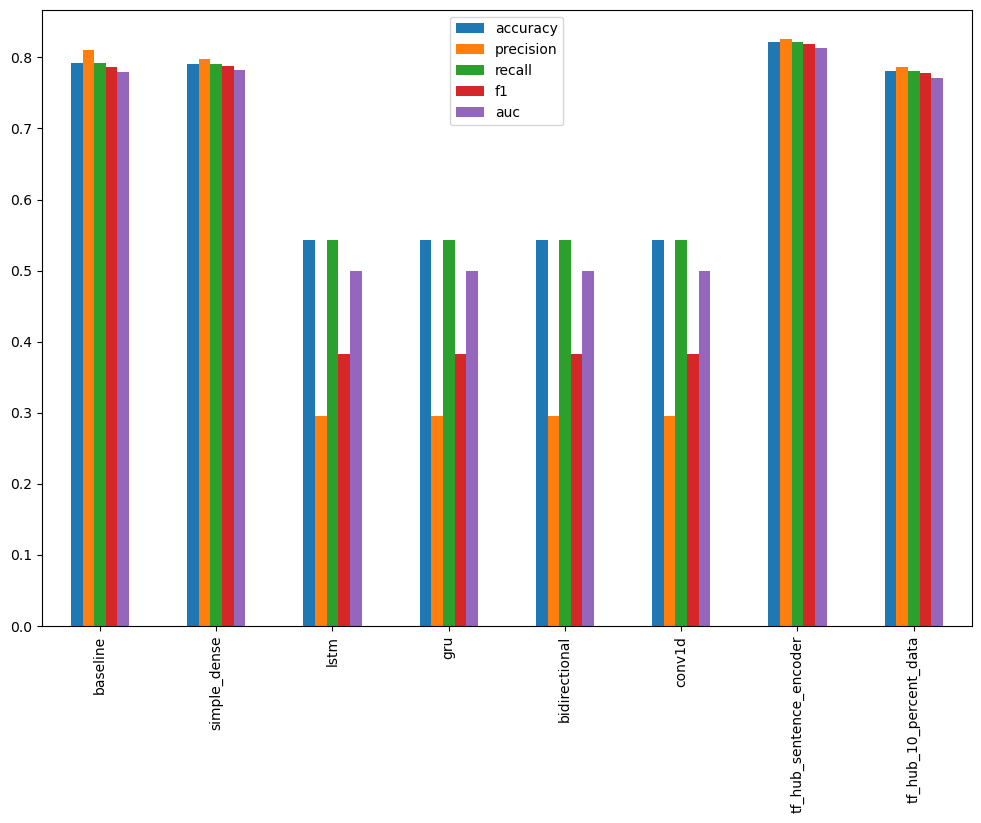

In [89]:
all_model_results.plot(kind='bar', figsize=(12,8))

<Axes: >

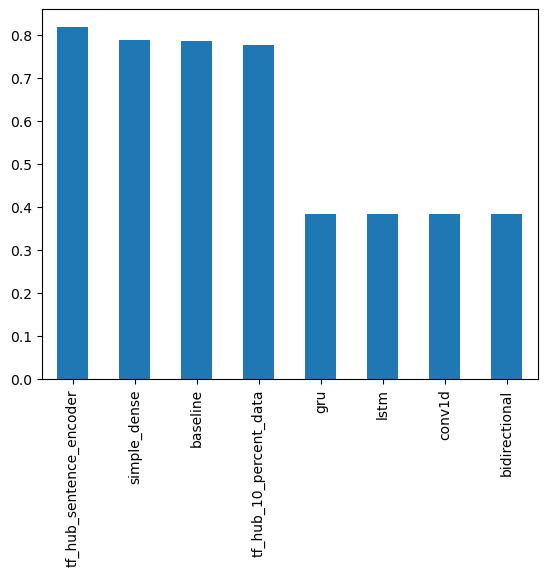

In [90]:
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar')

In [91]:
# 可以查看tensor board中的训练日志

## Combining our models (model ensembling/stacking)  多模型联合，平均/堆叠

Many production systems use an **ensemble** (multiple different models combined) of models to make a prediction.

The idea behind model stacking is that if several uncorrelated models agree on a prediction, then the prediction must be more robust than a prediction made by a singular model.

The keyword in the sentence above is **uncorrelated**, which is another way of saying, different types of models. For example, in our case, we might combine our baseline, our bidirectional model and our TensorFlow Hub USE model.

Although these models are all trained on the same data, they all have a different way of finding patterns.

If we were to use three similarly trained models, such as three LSTM models, the predictions they output will likely be very similar.

Think of it as trying to decide where to eat with your friends. If you all have similar tastes, you'll probably all pick the same restaurant. But if you've all got different tastes and still end up picking the same restaurant, the restaurant must be good.

选择不同的模型，联合方式：平均值，多数投票，堆叠

Since we're working with a classification problem, there are a few of ways we can combine our models:
1. **Averaging** - Take the output prediction probabilities of each model for each sample, combine them and then average them.
2. **Majority vote (mode)** - Make class predictions with each of your models on all samples, the predicted class is the one in majority. For example, if three different models predict `[1, 0, 1]` respectively, the majority class is `1`, therefore, that would be the predicted label.
3. **Model stacking** - Take the outputs of each of your chosen models and use them as inputs to another model.

> 📖 **Resource:** The above methods for model stacking/ensembling were adapted from Chapter 6 of the [Machine Learning Engineering Book](http://www.mlebook.com/wiki/doku.php) by Andriy Burkov. If you're looking to enter the field of machine learning engineering, not only building models but production-scale machine learning systems, I'd highly recommend reading it in its entirety.

Again, the concept of model stacking is best seen in action.

We're going to combine our baseline model (`model_0`), LSTM model (`model_2`) and our USE model trained on the full training data (`model_6`) by averaging the combined prediction probabilities of each.

In [93]:
# 三个模型的均值
baseline_pred_probs = np.max(model0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model2_pred_probs, axis=1) + tf.squeeze(model6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [94]:
ensemble_results = calculate_results(val_labels,combined_preds)
ensemble_results

{'accuracy': 0.7611548556430446,
 'precision': 0.8132090847515028,
 'recall': 0.7611548556430446,
 'f1': 0.7444674114407813,
 'auc': 0.7407962685324004}

In [95]:
all_model_results.loc["ensemble_results"] = ensemble_results
all_model_results

,accuracy,precision,recall,f1,auc
baseline,0.792651,0.811139,0.792651,0.786219,0.779402
simple_dense,0.791339,0.797601,0.791339,0.788036,0.782088
lstm,0.543307,0.295183,0.543307,0.382533,0.500000
gru,0.543307,0.295183,0.543307,0.382533,0.500000
bidirectional,0.543307,0.295183,0.543307,0.382533,0.500000
conv1d,0.543307,0.295183,0.543307,0.382533,0.500000
tf_hub_sentence_encoder,0.821522,0.826025,0.821522,0.819480,0.813989
tf_hub_10_percent_data,0.780840,0.786125,0.780840,0.777528,0.771739
ensemble_results,0.761155,0.813209,0.761155,0.744467,0.740796


How did the stacked model go against the other models?

> 🔑 **Note:** It seems many of our model's results are similar. This may mean there are some limitations to what can be learned from our data. When many of your modelling experiments return similar results, it's a good idea to revisit your data, we'll do this shortly.

## Saving and loading a trained model

Although training time didn't take very long, it's good practice to save your trained models to avoid having to retrain them.

Saving your models also enables you to export them for use elsewhere outside of your notebooks, such as in a web application.

There are two main ways of [saving a model in TensorFlow](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model):
1. The `HDF5` format. 
2. The `SavedModel` format (default).

Let's take a look at both.

In [96]:
model6.save('model6.h5')

If you save a model as a `HDF5`, when loading it back in, you need to let [TensorFlow know about any custom objects you've used](https://www.tensorflow.org/tutorials/keras/save_and_load#saving_custom_objects) (e.g. components which aren't built from pure TensorFlow, such as TensorFlow Hub components).

h5的格式，加载的时候，需要让tensorflow知道，使用了哪些自定义对象（比如，不是纯tensorflow的组件，如tensorflow hub的组件）

In [98]:
load_model6 = tf.keras.models.load_model('model6.h5',custom_objects={'KerasLayer':hub.KerasLayer})
load_model6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [99]:
load_model6.evaluate(val_sentences,val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4289 - accuracy: 0.8215


[0.4289405941963196, 0.8215222954750061]

In [100]:
model6.save('model6_SavedModel_format')

INFO:tensorflow:Assets written to: model6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model6_SavedModel_format/assets


If you use SavedModel format (default), you can reload your model without specifying custom objects using the [`tensorflow.keras.models.load_model()`](https://www.tensorflow.org/tutorials/keras/save_and_load) function.

In [101]:
# savedmodel format 格式，可以直接加载使用
load_model6_SavedModel = tf.keras.models.load_model("model6_SavedModel_format")
load_model6_SavedModel

In [102]:
load_model6_SavedModel.evaluate(val_sentences,val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4289 - accuracy: 0.8215


[0.4289405941963196, 0.8215222954750061]

As you can see saving and loading our model with either format results in the same performance.

> 🤔 **Question:** Should you used the `SavedModel` format or `HDF5` format?

For most use cases, the `SavedModel` format will suffice. However, this is a TensorFlow specific standard. If you need a more general-purpose data standard, `HDF5` might be better. For more, check out the [TensorFlow documentation on saving and loading models](https://www.tensorflow.org/tutorials/keras/save_and_load).

## Finding the most wrong examples  错的最离谱的样本

We mentioned before that if many of our modelling experiments are returning similar results, despite using different kinds of models, it's a good idea to return to the data and inspect why this might be.

One of the best ways to inspect your data is to sort your model's predictions and find the samples it got *most* wrong, meaning, what predictions had a high prediction probability but turned out to be wrong.

Once again, visualization is your friend. Visualize, visualize, visualize.

To make things visual, let's take our best performing model's prediction probabilities and classes along with the validation samples (text and ground truth labels) and combine them in a pandas DataFrame.

* If our best model still isn't perfect, what examples is it getting wrong? 
* Which ones are the *most* wrong?
* Are there some labels which are wrong? E.g. the model gets it right but the ground truth label doesn't reflect this

In [105]:
val_df = pd.DataFrame({"text":val_sentences,
                       "target":val_labels,
                       "pred":model6_preds,
                       "pred_prob":tf.squeeze(model6_pred_probs)
                       })
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.132109
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.749391
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.995240
3,@camilacabello97 Internally and externally scr...,1,0.0,0.228840
4,Radiation emergency #preparedness starts with ...,1,1.0,0.654380


In [106]:
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.904628
628,@noah_anyname That's where the concentration c...,0,1.0,0.896122
381,Deaths 3 http://t.co/nApviyGKYK,0,1.0,0.873395
759,FedEx will no longer transport bioterror patho...,0,1.0,0.867095
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.865158
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.842524
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.832282
474,My phone looks like it was in a car ship airpl...,0,1.0,0.814265
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.809073
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.768614


In [107]:
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9046280384063721
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8961215019226074
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8733946681022644
Text:
Deaths 3 http://t.co/nApviyGKYK

----

Target: 0, Pred: 1, Prob: 0.867094874382019
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8651583194732666
Text:
[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY

----

Target: 0, Pred: 1, Prob: 0.8425237536430359
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1, Prob: 0.8322820067405701
Text:
@madonnamking RSPCA site multi

In [108]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
# 预测为0的，但实际为1，错的最离谱的样本
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.05307368189096451
Text:
VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP WATCH 241487 http://t.co/yFy3nkkcoH http://t.co/KNEhVvOHVK

----

Target: 1, Pred: 0, Prob: 0.04697379842400551
Text:
Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvNJ4sAP

----

Target: 1, Pred: 0, Prob: 0.04614143446087837
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0, Prob: 0.04559875652194023
Text:
New post from @darkreading http://t.co/8eIJDXApnp New SMB Relay Attack Steals User Credentials Over Internet

----

Target: 1, Pred: 0, Prob: 0.04295254126191139
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0, Prob: 0.0395207479596138
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob

## Making predictions on the test dataset  测试集预测效果

Alright we've seen how our model's perform on the validation set.

But how about the test dataset?

We don't have labels for the test dataset so we're going to have to make some predictions and inspect them for ourselves.

Let's write some code to make predictions on random samples from the test dataset and visualize them.

In [110]:
test_sentences = test_df["text"].tolist()
test_random = random.sample(test_sentences, 10)
for sentence in test_random:
    pred_prob = tf.squeeze(model6.predict([sentence]))
    pred = tf.round(pred_prob)
    print(f"Pred: {int(pred)}, Prob: {pred_prob}")
    print(f"Text:\n{sentence}\n")
    print("----\n")


1/1 [==============================] - 0s 33ms/step
Pred: 0, Prob: 0.32714521884918213
Text:
@lordjewcup @helloimivan wounded warrior

----

1/1 [==============================] - 0s 31ms/step
Pred: 1, Prob: 0.9390918016433716
Text:
Striking views of Super Typhoon Soudelor as it tracks toward Taiwan China http://t.co/hsjp6Hoffe

----

1/1 [==============================] - 0s 30ms/step
Pred: 1, Prob: 0.9940610527992249
Text:
BBC News - MH370: Reunion debris is from missing Malaysia flight http://t.co/bze47fzKUd

----

1/1 [==============================] - 0s 29ms/step
Pred: 0, Prob: 0.08041217923164368
Text:
@FollowerOfDole 'Give me your lunch money ner-' *flattened by falling quarter*

----

1/1 [==============================] - 0s 29ms/step
Pred: 0, Prob: 0.02462243102490902
Text:
Body bagging that I think it's time to bring bags out

----

1/1 [==============================] - 0s 29ms/step
Pred: 1, Prob: 0.7288753986358643
Text:
@MalikChaimaa I hope Zayn gets blown up in a drone 

## Predicting on Tweets from the wild 预测原生的tweet

How about we find some Tweets and use our model to predict whether or not they're about a diaster or not?

To start, let's take one of my own [Tweets on living life like an ensemble model](https://twitter.com/mrdbourke/status/1313649328351662082). 

In [111]:
daniels_tweet = "Life like an ensemble: take the best choices from others and make your own"

In [112]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [113]:
predict_on_sentence(model=model6, sentence=daniels_tweet)

1/1 [==============================] - 0s 33ms/step
Pred: 0.0 (not real disaster) Prob: 0.055655840784311295
Text:
Life like an ensemble: take the best choices from others and make your own


In [114]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [115]:
predict_on_sentence(model=model6, sentence=beirut_tweet_1)
predict_on_sentence(model=model6, sentence=beirut_tweet_2)

1/1 [==============================] - 0s 31ms/step
Pred: 1.0 (real disaster) Prob: 0.9816731214523315
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon
1/1 [==============================] - 0s 29ms/step
Pred: 1.0 (real disaster) Prob: 0.9849336743354797
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


## The speed/score tradeoff  速度和分数的权衡

One of the final tests we're going to do is to find the speed/score tradeoffs between our best model and baseline model.

Why is this important?

Although it can be tempting to just choose the best performing model you find through experimentation, this model might not actually work in a production setting.

Put it this way, imagine you're Twitter and receive 1 million Tweets per hour (this is a made up number, the actual number is much higher). And you're trying to build a diaster detection system to read Tweets and alert authorities with details about a diaster in close to real-time.

Compute power isn't free so you're limited to a single compute machine for the project. On that machine, one of your models makes 10,000 predictions per second at 80% accuracy where as another one of your models (a larger model) makes 100 predictions per second at 85% accuracy.

Which model do you choose?

Is the second model's performance boost worth missing out on the extra capacity?

Of course, there are many options you could try here, such as sending as many Tweets as possible to the first model and then sending the ones which the model is least certain of to the second model. 

The point here is to illustrate the best model you find through experimentation, might not be the model you end up using in production.

To make this more concrete, let's write a function to take a model and a number of samples and time how long the given model takes to make predictions on those samples.

In [116]:
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  
  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [117]:
model6_total_pred_time, model6_time_per_pred = pred_timer(model6, val_sentences)
model6_total_pred_time, model6_time_per_pred

24/24 [==============================] - 0s 3ms/step


(0.12266498431563377, 0.00016097766970555612)

In [118]:
model0_total_pred_time, model0_time_per_pred = pred_timer(model0, val_sentences)
model0_total_pred_time, model0_time_per_pred

(0.010715180076658726, 1.406191611110069e-05)

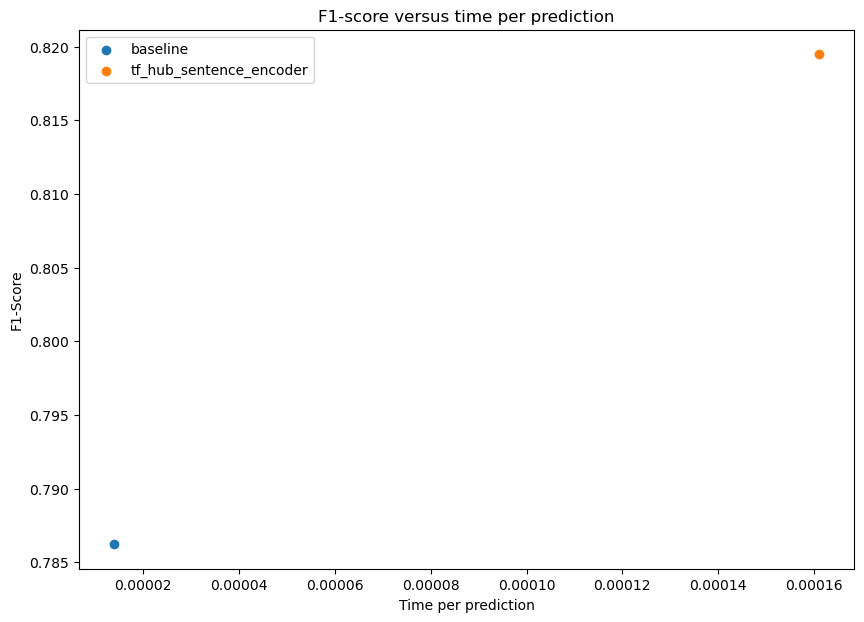

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(model0_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model6_time_per_pred, model6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-ideal-performance-speed-of-pred-tradeoff-highlighted.png)
*Ideal position for speed and performance tradeoff model (fast predictions with great results).*

Of course, the ideal position for each of these dots is to be in the top left of the plot (low time per prediction, high F1-score). 

In our case, there's a clear tradeoff for time per prediction and performance. Our best performing model takes an order of magnitude longer per prediction but only results in a few F1-score point increase.

This kind of tradeoff is something you'll need to keep in mind when incorporating machine learning models into your own applications.

## 🛠 Exercises

1. Rebuild, compile and train `model_1`, `model_2` and `model_5` using the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) instead of the Functional API.
2. Retrain the baseline model with 10% of the training data. How does perform compared to the Universal Sentence Encoder model with 10% of the training data?
3. Try fine-tuning the TF Hub Universal Sentence Encoder model by setting `training=True` when instantiating it as a Keras layer.

```
We can use this encoding layer in place of our text_vectorizer and embedding layer

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True) # turn training on to fine-tune the TensorFlow Hub model
```
4. Retrain the best model you've got so far on the whole training set (no validation split). Then use this trained model to make predictions on the test dataset and format the predictions into the same format as the `sample_submission.csv` file from Kaggle (see the Files tab in Colab for what the `sample_submission.csv` file looks like). Once you've done this, [make a submission to the Kaggle competition](https://www.kaggle.com/c/nlp-getting-started/data), how did your model perform?
5. Combine the ensemble predictions using the majority vote (mode), how does this perform compare to averaging the prediction probabilities of each model?
6. Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.

## 📖 Extra-curriculum 

To practice what you've learned, a good idea would be to spend an hour on 3 of the following (3-hours total, you could through them all if you want) and then write a blog post about what you've learned.

* For an overview of the different problems within NLP and how to solve them read through: 
 * [A Simple Introduction to Natural Language Processing](https://becominghuman.ai/a-simple-introduction-to-natural-language-processing-ea66a1747b32)
 * [How to solve 90% of NLP problems: a step-by-step guide](https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e)
* Go through [MIT's Recurrent Neural Networks lecture](https://youtu.be/SEnXr6v2ifU). This will be one of the greatest additions to what's happening behind the RNN model's you've been building.
* Read through the [word embeddings page on the TensorFlow website](https://www.tensorflow.org/tutorials/text/word_embeddings). Embeddings are such a large part of NLP. We've covered them throughout this notebook but extra practice would be well worth it. A good exercise would be to write out all the code in the guide in a new notebook. 
* For more on RNN's in TensorFlow, read and reproduce [the TensorFlow RNN guide](https://www.tensorflow.org/guide/keras/rnn). We've covered many of the concepts in this guide, but it's worth writing the code again for yourself.
* Text data doesn't always come in a nice package like the data we've downloaded. So if you're after more on preparing different text sources for being with your TensorFlow deep learning models, it's worth checking out the following:
 * [TensorFlow text loading tutorial](https://www.tensorflow.org/tutorials/load_data/text).
  * [Reading text files with Python](https://realpython.com/read-write-files-python/) by Real Python.
* This notebook has focused on writing NLP code. For a mathematically rich overview of how NLP with Deep Learning happens, read [Standford's Natural Language Processing with Deep Learning lecture notes Part 1](https://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes01-wordvecs1.pdf).  
  * For an even deeper dive, you could even do the whole [CS224n](http://web.stanford.edu/class/cs224n/) (Natural Language Processing with Deep Learning) course. 
* Great blog posts to read:
  * Andrei Karpathy's [The Unreasonable Effectiveness of RNNs](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) dives into generating Shakespeare text with RNNs.
  * [Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT](https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794) by Mauro Di Pietro. An overview of different techniques for turning text into numbers and then classifying it.
  * [What are word embeddings?](https://machinelearningmastery.com/what-are-word-embeddings/) by Machine Learning Mastery.
* Other topics worth looking into:
  * [Attention mechanisms](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/). These are a foundational component of the transformer architecture and also often add improvments to deep NLP models.
  * [Transformer architectures](http://jalammar.github.io/illustrated-transformer/). This model architecture has recently taken the NLP world by storm, achieving state of the art on many benchmarks. However, it does take a little more processing to get off the ground, the [HuggingFace Models (formerly HuggingFace Transformers) library](https://huggingface.co/models/) is probably your best quick start.
    * And now [HuggingFace even have their own course](https://huggingface.co/course/chapter1) on how their library works! I haven't done it but anything HuggingFace makes is world-class.

